# Correlation Coefficients and Graphs

For Target Varaible (DEP_DELAY) only. Trying to understand dep_delay's distribution and skewness and how to imporve it before training the model

In [271]:
# import modules 
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
%matplotlib inline 

In [272]:
df = pd.read_csv('../cleaning-preprocessing/cleaned_flight_data_with_target.csv')
df.head(5)

,MONTH,DAY_OF_MONTH,DAY_OF_WEEK,CRS_ELAPSED_TIME,DISTANCE,CRS_DEP_M,CRS_ARR_M,Temperature,Dew Point,Humidity,...,Condition_Light Snow / Windy,Condition_Mostly Cloudy,Condition_Mostly Cloudy / Windy,Condition_Partly Cloudy,Condition_Partly Cloudy / Windy,Condition_Rain,Condition_Rain / Windy,Condition_Snow,Condition_Wintry Mix,Condition_Wintry Mix / Windy
0,11,1,5,124,636,324,448,48,34,58,...,False,False,False,False,False,False,False,False,False,False
1,11,1,5,371,2475,340,531,48,34,58,...,False,False,False,False,False,False,False,False,False,False
2,11,1,5,181,1069,301,482,48,34,58,...,False,False,False,False,False,False,False,False,False,False
3,11,1,5,168,944,345,513,48,34,58,...,False,False,False,False,False,False,False,False,False,False
4,11,1,5,139,760,360,499,46,32,58,...,False,False,False,False,False,False,False,False,False,False


In [273]:
# Considering any flight is delay after 15 minutes
df = df[df['DEP_DELAY'] >= 15]

# Filtering df with Features Outiler Requirments (From training_feature_analysis)
df = df[df['CRS_ELAPSED_TIME'] < 600]
df = df[df['DISTANCE'] < 4000]
df = df[df['CRS_ARR_M'] > 400]

### Removing Outilers

In [274]:
# Compute IQR
Q1 = df['DEP_DELAY'].quantile(0.25)
Q3 = df['DEP_DELAY'].quantile(0.75)
IQR = Q3 - Q1

# Define lower and upper bounds
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

df = df[(df['DEP_DELAY'] >= lower_bound) & (df['DEP_DELAY'] <= upper_bound)]

In [275]:
print(df['DEP_DELAY'].skew())  # If > 0.5 or < -0.5, transformation is needed

df['DEP_DELAY_shifted'] = df['DEP_DELAY'] - df['DEP_DELAY'].min() + 1

df['DEP_DELAY_log'] = np.log1p(df['DEP_DELAY_shifted'])  # log1p avoids log(0) issue
print(df['DEP_DELAY_log'].skew())

df['DEP_DELAY_sqrt'] = np.sqrt(df['DEP_DELAY_shifted']) # sqrt version 
print(df['DEP_DELAY_sqrt'].skew())

1.2737285987243516
-0.2928965675492852
0.5152640702149736


In [276]:
X = df.drop(columns=['DEP_DELAY_sqrt','DEP_DELAY_log', 'DEP_DELAY','DEP_DELAY_shifted']) #Dropping DEP_DELAY Log/Sqrt transform cols

# Using Single Log Transformation
y = df['DEP_DELAY_log']  # Target variable

# Using Single Sqrt Transformation
# y = df['DEP_DELAY_sqrt']  # Target variable

y.head(3)

2     3.295837
14    4.553877
36    2.772589
Name: DEP_DELAY_log, dtype: float64

### Feature Selection

In [277]:
X = X.applymap(lambda x: max(x, 0))
X = X.fillna(X.mean())

/var/folders/06/6rnd9mvj2tg64m2vg9cssn0w0000gn/T/ipykernel_36516/3256436071.py:1: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  X = X.applymap(lambda x: max(x, 0))


In [278]:
k_num_features = 10

In [279]:
from sklearn.feature_selection import SelectKBest, f_regression
from sklearn.preprocessing import StandardScaler

# Standardize numerical features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Apply SelectKBest with f_regression
k = k_num_features  # Number of top features to select
selector = SelectKBest(score_func=f_regression, k=k)
X_selected = selector.fit_transform(X_scaled, y)

# Get selected feature names
selected_features = X.columns[selector.get_support()]
feature_scores = selector.scores_[selector.get_support()]

# Create a DataFrame with feature names and scores
feature_df = pd.DataFrame({'Feature': selected_features, 'F-Score': feature_scores})
feature_df = feature_df.sort_values(by='F-Score', ascending=False)

# Print the selected features
print("Selected Features:")
print(feature_df)

Selected Features:
                    Feature    F-Score
4                   sch_dep  75.521311
5      OP_UNIQUE_CARRIER_DL  40.861789
1                  DISTANCE  24.387498
0          CRS_ELAPSED_TIME  24.108637
3                  Pressure  16.067609
9  Condition_Cloudy / Windy   9.040915
2                Wind Speed   8.352767
6                  DEST_BOS   8.338327
8                  DEST_RDU   8.014278
7                  DEST_BUF   7.416724


### Split Data Training and Test Set

In [280]:
from sklearn.model_selection import train_test_split 

# X = X[['MONTH', 'CRS_DEP_M', 'CRS_ARR_M', 'Wind Speed']]

X_train, X_test, y_train, y_test = train_test_split(X[feature_df['Feature']], y, test_size = 0.2, random_state = 42)

### Model Training

In [281]:
# from sklearn.linear_model import LinearRegression
# regressor = LinearRegression()
# regressor.fit(X_train, y_train)

# from sklearn.tree import DecisionTreeRegressor  #BEST
# regressor = DecisionTreeRegressor(random_state = 0)
# regressor.fit(X_train, y_train)

# from sklearn.ensemble import RandomForestRegressor
# regressor = RandomForestRegressor(n_estimators = 10, random_state = 0)
# regressor.fit(X_train, y_train)

# from sklearn.svm import SVR # Good with small dataset
# regressor = SVR(kernel = 'rbf')
# regressor.fit(X_train, y_train)

# from sklearn.linear_model import Ridge
# regressor = Ridge(alpha=0.5)  # You can adjust alpha (regularization strength)
# regressor.fit(X_train, y_train)

from sklearn.neighbors import KNeighborsRegressor
regressor = KNeighborsRegressor(n_neighbors=9, metric='manhattan', weights='distance')
regressor.fit(X_train, y_train)

KNeighborsRegressor(metric='manhattan', n_neighbors=9, weights='distance')

### Trasnform Back

In [282]:
y_pred = regressor.predict(X_test)

# 1 log transformation
y_pred = np.exp(y_pred)
y_test = np.exp(y_test)

# 2 Sqrt trasnfromation 
# y_pred = (y_pred)**2
# y_test = (y_test)**2

### Results

In [283]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print("\nModel Performance Metrics:")
print(f"Mean Squared Error (MSE): {mse:.2f}")
print(f"Mean Absolute Error (MAE): {mae:.2f}")
# print(f"R Sqaure Score {r2}")
print(f"Average Prediction {np.mean(y_pred)}")


Model Performance Metrics:
Mean Squared Error (MSE): 987.38
Mean Absolute Error (MAE): 22.33
Average Prediction 23.246959070259944


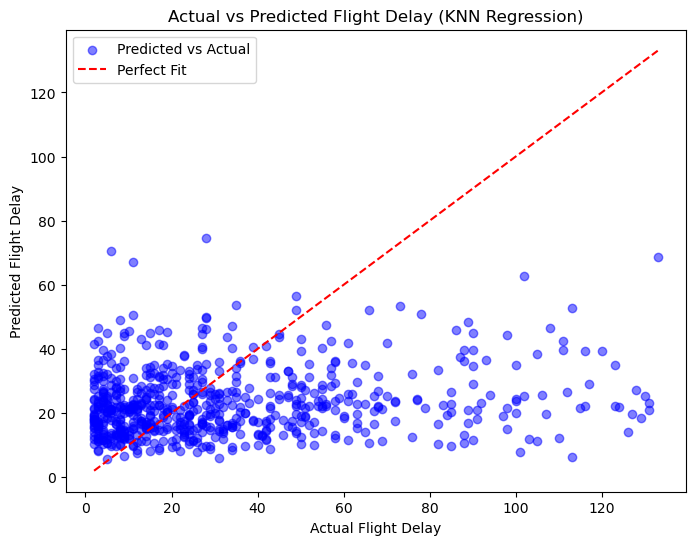

In [284]:
plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred, color='blue', alpha=0.5, label="Predicted vs Actual")
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red', linestyle='--', label="Perfect Fit")

plt.xlabel("Actual Flight Delay")
plt.ylabel("Predicted Flight Delay")
plt.title("Actual vs Predicted Flight Delay (KNN Regression)")
plt.legend()
# plt.grid(True)
plt.show()

In [285]:
from sklearn.model_selection import GridSearchCV

param_grid = {'n_neighbors': range(3, 11, 2)}
grid = GridSearchCV(KNeighborsRegressor(), param_grid, cv=5, scoring='r2')
grid.fit(X_train, y_train)
print("Best k:", grid.best_params_)

Best k: {'n_neighbors': 9}
